## Problem Statement 

Build a model that is able to classify customer complaints based on the products/services. By doing so, these tickets can be segregated into their relevant categories and, therefore, help in the quick resolution of the issue.
Need to do topic modelling on the json data provided by the company. Since this data is not labelled, NMF needs to be applied to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, each ticket can be mapped onto its respective department/category. This data can be used to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, any new customer complaint support ticket can be classified into into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json 
import numpy as np
import pandas as pd
import os, re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from pprint import pprint


import re

# tokenizer loading
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('punkt')


# stopwords loading
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# Lemmetization loading
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load spacy
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

# loading wordcloud
from wordcloud import WordCloud

# Models

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Loading dataset from google drive (skip this if loading from local drive)

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/NLP Projects/Ticket classification/

Mounted at /content/drive
/content/drive/My Drive/NLP Projects/Ticket classification


## Loding dataset from local drive

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file 
with open('complaints.json') as jsfile:
  # returns JSON object as  
  # a dictionary 
  data = json.load(jsfile)
  df=pd.json_normalize(data)

## Data preparation

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
#print the column names
cols = df.columns
print(cols)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [ ]:
#Assign new column names
# There are only following columns useful for the problem hence creating a new dataframe with just these 3 cols
# _source.issue , _source.product and _source.complaint_what_happened

df_new = pd.DataFrame(df[['_source.issue','_source.product','_source.complaint_what_happened']].values,columns = ['issue','product','complaint'])
df_new.head()

,issue,product,complaint
0,Attempts to collect debt not owed,Debt collection,
1,Written notification about debt,Debt collection,Good morning my name is XXXX XXXX and I apprec...
2,"Other features, terms, or problems",Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Trouble during payment process,Mortgage,
4,Fees or interest,Credit card or prepaid card,


In [ ]:
#Assign nan in place of blanks in the complaints column
blank_complaint_count = df_new[df_new['complaint'].str.len() == 0].shape[0]
print(f'Records where complaint is blank:\ncount : {blank_complaint_count}\npercentage of records : {round(blank_complaint_count*100/len(df_new),2)}')

# Replacing these records with nan
df_new.loc[df_new['complaint'].str.len() == 0,['complaint']] = np.nan

Records where complaint is blank:
count : 57241
percentage of records : 73.09


In [ ]:
#Remove all rows where complaints column is nan
df_new.dropna(inplace=True)
df_new.reset_index(drop=True,inplace=True)
df_new.shape

(21072, 3)

In [ ]:
df_new.head()

,issue,product,complaint
0,Written notification about debt,Debt collection,Good morning my name is XXXX XXXX and I apprec...
1,"Other features, terms, or problems",Credit card or prepaid card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
2,Incorrect information on your report,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...
3,Incorrect information on your report,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX..."
4,Managing an account,Checking or savings account,my grand son give me check for {$1600.00} i de...


In [ ]:
df_new.iloc[0].complaint

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
import string
string.punctuation



def removePunctuation(text):
  return text.translate(str.maketrans('','',string.punctuation))

def remove_text_in_square_bracket(document):
  return re.sub('\[(.*?)\]','',document)

def remove_masked_data_and_numbers(document):
  # regular expression to remove masked information represented by xxx's and all numbers
  return re.sub('xx+\d*|\d+','',document)

def clean_text_data(document):
  document = document.lower()
  document = remove_masked_data_and_numbers(document)
  document = remove_text_in_square_bracket(document)
  document = removePunctuation(document)
  words = word_tokenize(document)
  tokens = [word for word in words if word not in stopwords] # removing stopwords from the document
  return ' '.join(tokens)


In [ ]:
# applying data cleaning method on complaints
df_new['complaint_clean'] = df_new.complaint.apply(clean_text_data)


In [ ]:
# After cleaning the text
df_new.complaint_clean[0]

'good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help'

In [ ]:
#Write your function to Lemmatize the texts
lm = WordNetLemmatizer()
def lemmetize_text(document):
  tokens = []
  for word in word_tokenize(document):
    tokens.append(lm.lemmatize(word))
  return ' '.join(tokens)



In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(df_new.complaint_clean)
df_clean['lemmetized_complaint'] = df_new.complaint_clean.apply(lemmetize_text)

In [ ]:
df_clean

,complaint_clean,lemmetized_complaint
0,good morning name appreciate could help put st...,good morning name appreciate could help put st...
1,upgraded card told agent upgrade anniversary d...,upgraded card told agent upgrade anniversary d...
2,chase card reported however fraudulent applica...,chase card reported however fraudulent applica...
3,trying book ticket came across offer applied t...,trying book ticket came across offer applied t...
4,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...
...,...,...
21067,chase card customer well decade offered multip...,chase card customer well decade offered multip...
21068,wednesday called chas visa credit card provide...,wednesday called chas visa credit card provide...
21069,familiar pay understand great risk provides co...,familiar pay understand great risk provides co...
21070,flawless credit yrs ive chase credit cards cha...,flawless credit yr ive chase credit card chase...


In [ ]:
#Write your function to extract the POS tags

def pos_tag_apply(text):
  tokens = []
  for tag in pos_tag(word_tokenize(text)):
    if tag[1] != 'NN':
      tokens.append(tag[0])
  return ' '.join(tokens)



df_clean["complaint_POS_removed"] = df_clean['lemmetized_complaint'].apply(pos_tag_apply) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_clean,lemmetized_complaint,complaint_POS_removed
0,good morning name appreciate could help put st...,good morning name appreciate could help put st...,good could help put stop wrote chase asking se...
1,upgraded card told agent upgrade anniversary d...,upgraded card told agent upgrade anniversary d...,upgraded told upgrade anniversary would change...
2,chase card reported however fraudulent applica...,chase card reported however fraudulent applica...,reported however fraudulent submitted without ...
3,trying book ticket came across offer applied t...,trying book ticket came across offer applied t...,trying came across applied towards applied rew...
4,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,grand give clear closed never paid said need s...
...,...,...,...
21067,chase card customer well decade offered multip...,chase card customer well decade offered multip...,well offered multiple acquiring new mile appro...
21068,wednesday called chas visa credit card provide...,wednesday called chas visa credit card provide...,called asked make purchased three high old tra...
21069,familiar pay understand great risk provides co...,familiar pay understand great risk provides co...,familiar understand great provides believed sa...
21070,flawless credit yrs ive chase credit cards cha...,flawless credit yr ive chase credit card chase...,yr ive specifically since ever ive done many p...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_len'] = df_clean['complaint_POS_removed'].str.len()
fig = px.histogram(df_clean, x="complaint_len",title='Complaint length histogram')
fig.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

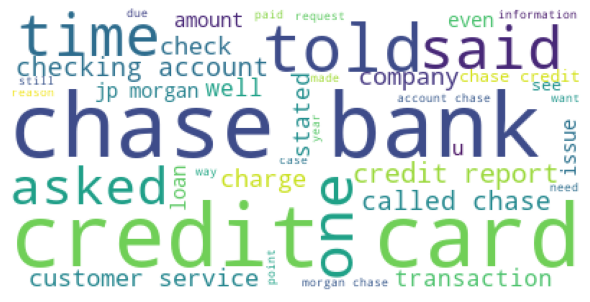

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
corpus = [sent for sent in df_clean['lemmetized_complaint']]
corpus = ' '.join(corpus)

word_cloud = WordCloud(max_words=40,background_color='white').generate(corpus)
plt.figure(figsize=(8,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['lemmetized_complaint'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

def word_frequency_unigram(sent):
  tokens = word_tokenize(sent)
  unigrams = Counter(tokens)
  return sorted(unigrams.items(), key = lambda x:x[1],reverse=True)[:30]


from nltk.util import ngrams
from collections import Counter
corpus = [sent for sent in df_clean['Complaint_clean']]
corpus = ' '.join(corpus)

unigram_freq = word_frequency_unigram(corpus)

In [ ]:
#Print the top 10 words in the unigram frequency
unigram_freq[:10]

[('chase', 80559),
 ('account', 48628),
 ('credit', 33100),
 ('card', 30535),
 ('bank', 28245),
 ('payment', 21182),
 ('would', 20318),
 ('told', 16378),
 ('time', 16048),
 ('called', 13409)]

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def word_frequency_bigram(sent):
  tokens = word_tokenize(sent)
  unigrams = Counter(ngrams(tokens,2))
  return sorted(unigrams.items(), key = lambda x:x[1],reverse=True)[:30]

bigram_freq = word_frequency_bigram(corpus)

In [ ]:
#Print the top 10 words in the bigram frequency
bigram_freq[:10]

[(('chase', 'bank'), 12802),
 (('credit', 'card'), 12791),
 (('credit', 'report'), 3869),
 (('checking', 'account'), 3747),
 (('called', 'chase'), 3717),
 (('customer', 'service'), 3067),
 (('jp', 'morgan'), 2887),
 (('chase', 'credit'), 2527),
 (('morgan', 'chase'), 2478),
 (('account', 'chase'), 2455)]

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def word_frequency_trigram(sent):
  tokens = word_tokenize(sent)
  unigrams = Counter(ngrams(tokens,3))
  return sorted(unigrams.items(), key = lambda x:x[1],reverse=True)[:30]

trigram_freq = word_frequency_trigram(corpus)

In [ ]:
#Print the top 10 words in the trigram frequency
trigram_freq[:10]

[(('jp', 'morgan', 'chase'), 2366),
 (('chase', 'credit', 'card'), 2248),
 (('credit', 'card', 'account'), 968),
 (('credit', 'card', 'company'), 955),
 (('credit', 'card', 'chase'), 727),
 (('morgan', 'chase', 'bank'), 677),
 (('account', 'chase', 'bank'), 663),
 (('chase', 'customer', 'service'), 581),
 (('received', 'letter', 'chase'), 477),
 (('chase', 'checking', 'account'), 446)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
# masked data has already been cleaned before
# df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint_clean,lemmetized_complaint,complaint_POS_removed,complaint_len,Complaint_clean
0,good morning name appreciate could help put st...,good morning name appreciate could help put st...,good could help put stop wrote chase asking se...,130,good morning name appreciate could help put st...
1,upgraded card told agent upgrade anniversary d...,upgraded card told agent upgrade anniversary d...,upgraded told upgrade anniversary would change...,111,upgraded card told agent upgrade anniversary d...
2,chase card reported however fraudulent applica...,chase card reported however fraudulent applica...,reported however fraudulent submitted without ...,90,chase card reported however fraudulent applica...
3,trying book ticket came across offer applied t...,trying book ticket came across offer applied t...,trying came across applied towards applied rew...,511,trying book ticket came across offer applied t...
4,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,grand give clear closed never paid said need s...,100,grand son give check deposit chase account fun...
...,...,...,...,...,...
21067,chase card customer well decade offered multip...,chase card customer well decade offered multip...,well offered multiple acquiring new mile appro...,210,chase card customer well decade offered multip...
21068,wednesday called chas visa credit card provide...,wednesday called chas visa credit card provide...,called asked make purchased three high old tra...,691,wednesday called chas visa credit card provide...
21069,familiar pay understand great risk provides co...,familiar pay understand great risk provides co...,familiar understand great provides believed sa...,842,familiar pay understand great risk provides co...
21070,flawless credit yrs ive chase credit cards cha...,flawless credit yr ive chase credit card chase...,yr ive specifically since ever ive done many p...,733,flawless credit yr ive chase credit card chase...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df = 0.95,min_df=2)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = num_topics,random_state=40)

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



14183

In [ ]:
#Print the Top15 words for each of the topics
W = nmf_model.transform(dtm)
H = nmf_model.components_
for i in range(5):
  top_15_words = tfidf.get_feature_names_out()[list(np.argsort(H[i])[::-1][:15])]
  print('For Topic-'+str(i)+' top 15 words:')
  print(top_15_words)
  print('*'*100)

For Topic-0 top 15 words:
['charge' 'card' 'chase' 'dispute' 'transaction' 'claim' 'fraud'
 'merchant' 'called' 'purchase' 'call' 'received' 'told' 'would' 'service']
****************************************************************************************************
For Topic-1 top 15 words:
['credit' 'card' 'report' 'inquiry' 'chase' 'hard' 'account' 'reporting'
 'score' 'bureau' 'company' 'removed' 'debt' 'closed' 'limit']
****************************************************************************************************
For Topic-2 top 15 words:
['loan' 'mortgage' 'chase' 'home' 'modification' 'property' 'year'
 'foreclosure' 'letter' 'document' 'bank' 'time' 'house' 'sale' 'rate']
****************************************************************************************************
For Topic-3 top 15 words:
['account' 'check' 'bank' 'chase' 'money' 'fund' 'checking' 'closed'
 'deposit' 'branch' 'told' 'day' 'would' 'deposited' 'said']
***********************************************

In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_labels = {0:'Theft/Dispute reporting',1:'Credit card/Prepaid card',2:'Mortgage/loans',3:'Bank account services',4:'Other'}


In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = np.argmax(W,axis=1) #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

,complaint_clean,lemmetized_complaint,complaint_POS_removed,complaint_len,Complaint_clean,Topic
0,good morning name appreciate could help put st...,good morning name appreciate could help put st...,good could help put stop wrote chase asking se...,130,good morning name appreciate could help put st...,2
1,upgraded card told agent upgrade anniversary d...,upgraded card told agent upgrade anniversary d...,upgraded told upgrade anniversary would change...,111,upgraded card told agent upgrade anniversary d...,0
2,chase card reported however fraudulent applica...,chase card reported however fraudulent applica...,reported however fraudulent submitted without ...,90,chase card reported however fraudulent applica...,1
3,trying book ticket came across offer applied t...,trying book ticket came across offer applied t...,trying came across applied towards applied rew...,511,trying book ticket came across offer applied t...,1
4,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,grand give clear closed never paid said need s...,100,grand son give check deposit chase account fun...,3


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean_new=df_clean.groupby('Topic').head(5)
df_clean_new.sort_values('Topic')[['complaint_clean','Topic']]

,complaint_clean,Topic
1,upgraded card told agent upgrade anniversary d...,0
8,made payment online retailer using chase quick...,0
19,made purchase amount charged twice transaction...,0
16,sofa love seat table chairs never delivered de...,0
14,chase amazon card declined catering order plac...,0
2,chase card reported however fraudulent applica...,1
3,trying book ticket came across offer applied t...,1
5,please remove inquiry,1
9,chase credit card incorrectly reporting data c...,1
11,reached several times attempt fraudulent inqui...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Theft/Dispute reporting',1:'Credit card/Prepaid card',2:'Mortgage/loans',3:'Bank account services',4:'Other'}
Topic_names_ind = {'Theft/Dispute reporting':0,'Credit card/Prepaid card':1,'Mortgage/loans':2,'Bank account services':3,'Other':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint_clean,lemmetized_complaint,complaint_POS_removed,complaint_len,Complaint_clean,Topic
0,good morning name appreciate could help put st...,good morning name appreciate could help put st...,good could help put stop wrote chase asking se...,130,good morning name appreciate could help put st...,Mortgage/loans
1,upgraded card told agent upgrade anniversary d...,upgraded card told agent upgrade anniversary d...,upgraded told upgrade anniversary would change...,111,upgraded card told agent upgrade anniversary d...,Theft/Dispute reporting
2,chase card reported however fraudulent applica...,chase card reported however fraudulent applica...,reported however fraudulent submitted without ...,90,chase card reported however fraudulent applica...,Credit card/Prepaid card
3,trying book ticket came across offer applied t...,trying book ticket came across offer applied t...,trying came across applied towards applied rew...,511,trying book ticket came across offer applied t...,Credit card/Prepaid card
4,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,grand give clear closed never paid said need s...,100,grand son give check deposit chase account fun...,Bank account services
...,...,...,...,...,...,...
21067,chase card customer well decade offered multip...,chase card customer well decade offered multip...,well offered multiple acquiring new mile appro...,210,chase card customer well decade offered multip...,Credit card/Prepaid card
21068,wednesday called chas visa credit card provide...,wednesday called chas visa credit card provide...,called asked make purchased three high old tra...,691,wednesday called chas visa credit card provide...,Theft/Dispute reporting
21069,familiar pay understand great risk provides co...,familiar pay understand great risk provides co...,familiar understand great provides believed sa...,842,familiar pay understand great risk provides co...,Theft/Dispute reporting
21070,flawless credit yrs ive chase credit cards cha...,flawless credit yr ive chase credit card chase...,yr ive specifically since ever ive done many p...,733,flawless credit yr ive chase credit card chase...,Other


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Replace Topic names with Topic indexes
df_clean['Topic'] = df_clean['Topic'].map(Topic_names_ind)

In [ ]:
df_clean

,complaint_clean,lemmetized_complaint,complaint_POS_removed,complaint_len,Complaint_clean,Topic
0,good morning name appreciate could help put st...,good morning name appreciate could help put st...,good could help put stop wrote chase asking se...,130,good morning name appreciate could help put st...,2
1,upgraded card told agent upgrade anniversary d...,upgraded card told agent upgrade anniversary d...,upgraded told upgrade anniversary would change...,111,upgraded card told agent upgrade anniversary d...,0
2,chase card reported however fraudulent applica...,chase card reported however fraudulent applica...,reported however fraudulent submitted without ...,90,chase card reported however fraudulent applica...,1
3,trying book ticket came across offer applied t...,trying book ticket came across offer applied t...,trying came across applied towards applied rew...,511,trying book ticket came across offer applied t...,1
4,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,grand give clear closed never paid said need s...,100,grand son give check deposit chase account fun...,3
...,...,...,...,...,...,...
21067,chase card customer well decade offered multip...,chase card customer well decade offered multip...,well offered multiple acquiring new mile appro...,210,chase card customer well decade offered multip...,1
21068,wednesday called chas visa credit card provide...,wednesday called chas visa credit card provide...,called asked make purchased three high old tra...,691,wednesday called chas visa credit card provide...,0
21069,familiar pay understand great risk provides co...,familiar pay understand great risk provides co...,familiar understand great provides believed sa...,842,familiar pay understand great risk provides co...,0
21070,flawless credit yrs ive chase credit cards cha...,flawless credit yr ive chase credit card chase...,yr ive specifically since ever ive done many p...,733,flawless credit yr ive chase credit card chase...,4


In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = pd.DataFrame()
training_data['complaint'] = df_new['complaint'].apply(clean_text_data)
training_data['topic'] = df_clean['Topic']

In [ ]:
training_data

,complaint,topic
0,good morning name appreciate could help put st...,2
1,upgraded card told agent upgrade anniversary d...,0
2,chase card reported however fraudulent applica...,1
3,trying book ticket came across offer applied t...,1
4,grand son give check deposit chase account fun...,3
...,...,...
21067,chase card customer well decade offered multip...,1
21068,wednesday called chas visa credit card provide...,0
21069,familiar pay understand great risk provides co...,0
21070,flawless credit yrs ive chase credit cards cha...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


#### Splitting the dataset into train and test

In [ ]:
X = training_data['complaint']
y = training_data['topic']

# Splitting the dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=100)

### Using TFIDF 

In [ ]:
# training tfidfvectorizer on the train dataset
tfidf_vec = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf_vec.fit_transform(X_train)
X_test_vec = tfidf_vec.transform(X_test)

# X_train_vec = preprocessing.normalize(X_train_vec)
# normalizer = MinMaxScaler()
# X_train_vec = normalizer.fit_transform(X_train_vec)
# X_test_vec = normalizer.transform(X_test_vec)

print(f'Shape of train data {X_train_vec.shape}')
print(f'Shape of test data {X_test_vec.shape}')

Shape of train data (14750, 5000)
Shape of test data (6322, 5000)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

#### Applying Logistic regression

In [ ]:
# Training the Logistic regression model
lr_model_tfidf = LogisticRegression(max_iter=200)
lr_model_tfidf.fit(X_train_vec,y_train)



LogisticRegression(max_iter=200)

##### Prediction on the test dataset

In [ ]:
test_pred = lr_model_tfidf.predict(X_test_vec)
print(f'Logistic regression model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = lr_model_tfidf.predict(X_train_vec)
print(f'Logistic regression model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Logistic regression model accuracy on test dataset : 0.95
Logistic regression model accuracy on train dataset : 1.0


In [ ]:
print(classification_report(test_pred,y_test))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1453
           1       0.94      0.95      0.95      1175
           2       0.93      0.97      0.95      1177
           3       0.97      0.94      0.96      1758
           4       0.91      0.97      0.94       759

    accuracy                           0.95      6322
   macro avg       0.94      0.95      0.95      6322
weighted avg       0.95      0.95      0.95      6322



#### Applying Decision Tree

In [ ]:
dt_model  = DecisionTreeClassifier()
dt_model.fit(X_train_vec,y_train)

DecisionTreeClassifier()

In [ ]:
test_pred = dt_model.predict(X_test_vec)
print(f'Decision Tree model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = dt_model.predict(X_train_vec)
print(f'Decision Tree model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Decision Tree model accuracy on test dataset : 0.76
Decision Tree model accuracy on train dataset : 1.0


In [ ]:
# Applying hyperparam tuning steps on the decision tree
dt_model  = DecisionTreeClassifier(max_depth = 20)
params = {
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

dt_gcv = GridSearchCV(estimator = dt_model,param_grid=params , cv=4, n_jobs = -1,verbose = 1, scoring = 'accuracy')
dt_gcv.fit(X_train_vec,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=20), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
best_dt = dt_gcv.best_estimator_

In [ ]:
test_pred = best_dt.predict(X_test_vec)
print(f'Optimised Decision Tree model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = best_dt.predict(X_train_vec)
print(f'Optimised Decision Tree model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Optimised Decision Tree model accuracy on test dataset : 0.78
Optimised Decision Tree model accuracy on train dataset : 0.85


#### Applying Naive Bayes theorem

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec,y_train)

MultinomialNB()

In [ ]:
test_pred = nb_model.predict(X_test_vec)
print(f'Naive Bayes model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = nb_model.predict(X_train_vec)
print(f'Naive Bayes model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Naive Bayes model accuracy on test dataset : 0.83
Naive Bayes model accuracy on train dataset : 0.85


In [ ]:
print(classification_report(test_pred,y_test))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1381
           1       0.79      0.83      0.81      1126
           2       0.85      0.89      0.87      1167
           3       0.92      0.77      0.84      2025
           4       0.65      0.84      0.73       623

    accuracy                           0.83      6322
   macro avg       0.81      0.84      0.82      6322
weighted avg       0.84      0.83      0.83      6322



#### Applying RandomForest

In [ ]:
rf_model = RandomForestClassifier(max_depth=30, min_samples_split=10,min_samples_leaf=10)
rf_model.fit(X_train_vec,y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=10, min_samples_split=10)

In [ ]:
test_pred = rf_model.predict(X_test_vec)
print(f'Random Forest model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = rf_model.predict(X_train_vec)
print(f'Random Forest model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Random Forest model accuracy on test dataset : 0.85
Random Forest model accuracy on train dataset : 0.91


In [ ]:
print(classification_report(test_pred,y_test))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1399
           1       0.86      0.87      0.86      1166
           2       0.87      0.91      0.89      1166
           3       0.95      0.80      0.87      1998
           4       0.66      0.90      0.76       593

    accuracy                           0.85      6322
   macro avg       0.83      0.87      0.85      6322
weighted avg       0.87      0.85      0.86      6322



### Using BOW

In [ ]:
# training Bag of words on the train dataset
bow_vec = CountVectorizer(max_features=5000)
X_train_vec = bow_vec.fit_transform(X_train)
X_test_vec = bow_vec.transform(X_test)

# X_train_vec = preprocessing.normalize(X_train_vec)
# normalizer = MinMaxScaler()
# X_train_vec = normalizer.fit_transform(X_train_vec)
# X_test_vec = normalizer.transform(X_test_vec)

print(f'Shape of train data {X_train_vec.shape}')
print(f'Shape of test data {X_test_vec.shape}')

Shape of train data (14750, 5000)
Shape of test data (6322, 5000)


#### Applying Logistic regression

In [ ]:
# Training the Logistic regression model
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_vec,y_train)



LogisticRegression(max_iter=200)

##### Prediction on the test dataset

In [ ]:
test_pred = lr_model.predict(X_test_vec)
print(f'Logistic regression model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = lr_model.predict(X_train_vec)
print(f'Logistic regression model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Logistic regression model accuracy on test dataset : 0.95
Logistic regression model accuracy on train dataset : 1.0


In [ ]:
print(classification_report(test_pred,y_test))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1423
           1       0.96      0.95      0.95      1192
           2       0.93      0.97      0.95      1176
           3       0.96      0.95      0.96      1714
           4       0.96      0.95      0.96       817

    accuracy                           0.95      6322
   macro avg       0.95      0.95      0.95      6322
weighted avg       0.95      0.95      0.95      6322



#### Applying Decision Tree

In [ ]:
dt_model  = DecisionTreeClassifier()
dt_model.fit(X_train_vec,y_train)

DecisionTreeClassifier()

In [ ]:
test_pred = dt_model.predict(X_test_vec)
print(f'Decision Tree model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = dt_model.predict(X_train_vec)
print(f'Decision Tree model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Decision Tree model accuracy on test dataset : 0.74
Decision Tree model accuracy on train dataset : 1.0


In [ ]:
# Applying hyperparam tuning steps on the decision tree
dt_model  = DecisionTreeClassifier(max_depth = 20)
params = {
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

dt_gcv = GridSearchCV(estimator = dt_model,param_grid=params , cv=4, n_jobs = -1,verbose = 1, scoring = 'accuracy')
dt_gcv.fit(X_train_vec,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=20), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
best_dt = dt_gcv.best_estimator_
best_dt

DecisionTreeClassifier(max_depth=20, min_samples_leaf=5)

In [ ]:
test_pred = best_dt.predict(X_test_vec)
print(f'Optimized Decision Tree model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = best_dt.predict(X_train_vec)
print(f'OptimizedvDecision Tree model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Optimized Decision Tree model accuracy on test dataset : 0.73
OptimizedvDecision Tree model accuracy on train dataset : 0.86


#### Applying Naive Bayes theorem

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec,y_train)

MultinomialNB()

In [ ]:
test_pred = nb_model.predict(X_test_vec)
print(f'Naive Bayes model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = nb_model.predict(X_train_vec)
print(f'Naive Bayes model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Naive Bayes model accuracy on test dataset : 0.85
Naive Bayes model accuracy on train dataset : 0.88


In [ ]:
print(classification_report(test_pred,y_test))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1364
           1       0.85      0.82      0.84      1222
           2       0.85      0.93      0.89      1121
           3       0.88      0.88      0.88      1705
           4       0.83      0.74      0.78       910

    accuracy                           0.85      6322
   macro avg       0.85      0.85      0.85      6322
weighted avg       0.85      0.85      0.85      6322



#### Applying RandomForest

In [ ]:
rf_model = RandomForestClassifier(max_depth=20, min_samples_split=10,min_samples_leaf=10)
rf_model.fit(X_train_vec,y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=10)

In [ ]:
test_pred = rf_model.predict(X_test_vec)
print(f'Random Forest model accuracy on test dataset : {round(accuracy_score(test_pred,y_test),2)}')
train_pred = rf_model.predict(X_train_vec)
print(f'Random Forest model accuracy on train dataset : {round(accuracy_score(train_pred,y_train),2)}')

Random Forest model accuracy on test dataset : 0.82
Random Forest model accuracy on train dataset : 0.86


In [ ]:
print(classification_report(test_pred,y_test))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1351
           1       0.83      0.82      0.83      1191
           2       0.83      0.90      0.86      1118
           3       0.94      0.74      0.83      2155
           4       0.57      0.91      0.70       507

    accuracy                           0.82      6322
   macro avg       0.79      0.84      0.81      6322
weighted avg       0.84      0.82      0.82      6322



# Conclusion


## ML Algorithms metrics:

### Using Bag of words (max\_features = 5000):

| ML Algo | Train Accuracy | Test Accuracy |
| --- | --- | --- |
| Logistic regression | 1 | 0.95 |
| Decision Tree | 0.82 | 0.75 |
| Naive Bayes | 0.88 | 0.85 |
| Random Forest | 0.85 | 0.82 |



### Using TFIDF (max\_features = 5000):

| ML Algo | Train Accuracy | Test Accuracy |
| --- | --- | --- |
| Logistic regression | 0.99 | 0.95 |
| Decision Tree | 0.85 | 0.78 |
| Naive Bayes | 0.85 | 0.83 |
| Random Forest | 0.91 | 0.86 |

# Random prediction

In [ ]:
def predictTicketCategory(text):
  vec_list = []
  text = clean_text_data(text)
  vec_list.append(text)
  text_vec = tfidf_vec.transform(vec_list)
  catg = lr_model_tfidf.predict(text_vec)
  return topic_labels.get(catg[0])


In [ ]:
import random 
ind = random.randint(0,len(df_new))
print('Index',ind)
complaint = df_new.iloc[ind]['complaint']

print('Complaint------\n\n',complaint)
result = predictTicketCategory(complaint)
print('\n\nIssue--------\n\n',df_new.iloc[ind]['issue'])
print('\n\nProduct--------\n\n',df_new.iloc[ind]['product'])
print('\n\nPredicted category for ticket--------\n\n',result)



Index 8245
Complaint------

 - On XX/XX/XXXX I sent a message via secure message on my home banking with Chase Bank asking how was the process to close my account. I never asked to effectively close my account, I just wanted to know how the process was because I was evaluating changing to another bank. I have all the messages in my Chase Inbox and screenshots of it just in case ( they're in XXXX ). 

- On XX/XX/XXXX I tried to access my account va online banking and there was no account and funds. I just found that a Chase 's employee answered my message saying that my account was closed and they have sent a check with my funds to my address ( they never said wich address exactly ). They also cancel all possible transactions and my debit card. 

- I contacted inmediately via secure inbox again and asked why they did this and said that it was a mistake. I asked for my money saying that I really need it and that I never asked to effectively close my account. I also sent them a screenshot

In [ ]:
import random 
ind = random.randint(0,len(df_new))
print('Index',ind)
complaint = df_new.iloc[ind]['complaint']

print('Complaint------\n\n',complaint)
result = predictTicketCategory(complaint)
print('\n\nIssue--------\n\n',df_new.iloc[ind]['issue'])
print('\n\nProduct--------\n\n',df_new.iloc[ind]['product'])
print('\n\nPredicted category for ticket--------\n\n',result)


Index 767
Complaint------

 JP Morgan Chase Bank XXXX has once again threatened me with foreclosure ( see attached ) while refusing to acknowledge wrong accounting and that the " alleged '' loan They " Say '' belongs to XXXX XXXX when in fact it does Not, as per the report from the FHFA-OIG in XXXX. Also, JP Morgan Chase Bank XXXX has Not fulfilled the RESPA ( see attached ) I sent them correctly and or in full, while the Mortgage and Promissary note and Allonge I had a document authenticator Expert examine and were found to be Fake and also Unattached, on XX/XX/XXXX at the office of Attorney XXXX XXXX XXXX, clip art, robo signed and etc ... were used to fabricate these documents! JP Morgan Chase Bank XXXX Claims to be the original from XXXX, in fact are not! but are FRAUD!! I will show this document only in court and my expert will be testifying to her report!! I have once again tried to get JP Morgan Chase Bank XXXX to look at the original transaction history they sent me in XXXX sho